In [192]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras.backend import clear_session
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import keras_cv

In [185]:
#gpuの確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-06-30 06:07:03.600681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2023] Ignoring visible gpu device (device: 1, name: Quadro P1000, pci bus id: 0000:65:00.0, compute capability: 6.1) with core count: 5. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2023-06-30 06:07:03.601369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /device:GPU:0 with 9382 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5953952989314071162
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9838657536
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2519890989711087657
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [186]:
# train50000, test10000のデータ。画像とラベルのタプルが返ってくる
cifar10, cifar10_metadata = tfds.load("cifar10", with_info=True, shuffle_files=True, as_supervised=True, batch_size=-1)

In [187]:
x_train, y_train = cifar10["train"]
x_test, y_test = cifar10["test"]
print(cifar10.keys())

dict_keys(['train', 'test'])


In [188]:
def plot_cifar10(images, labels, figure_array=None, figsize=None):
    cifar10_labels = np.array([
        "airplane", 
        "automobile", 
        "bird", 
        "cat", 
        "deer", 
        "dog", 
        "frog", 
        "horse", 
        "ship", 
        "truck"
    ])

    if figure_array is None:
        figure_array = [3, 10]

    fig = plt.figure(figsize=figsize)
    for i in range(figure_array[0]*figure_array[1]):
        ax = fig.add_subplot(figure_array[0], figure_array[1], i+1)
        ax.imshow(images[i])
        ax.set_title(cifar10_labels[labels[i]])
        ax.axis("off")

def plot_cifar10_miss(images, real_labels, predicted_labels, figure_array=None, figsize=None):
    cifar10_labels = np.array([
        "airplane", 
        "automobile", 
        "bird", 
        "cat", 
        "deer", 
        "dog", 
        "frog", 
        "horse", 
        "ship", 
        "truck"
    ])

    if figure_array is None:
        figure_array = [3, 10]

    fig = plt.figure(figsize=figsize)
    count = 0
    i = 0
    while count!=figure_array[0]*figure_array[1]:
        if real_labels[i] != predicted_labels[i]:
            ax = fig.add_subplot(figure_array[0], figure_array[1], count+1)
            ax.imshow(images[i])
            ax.set_title(cifar10_labels[predicted_labels[i]])
            ax.axis("off")
            count += 1
        i += 1

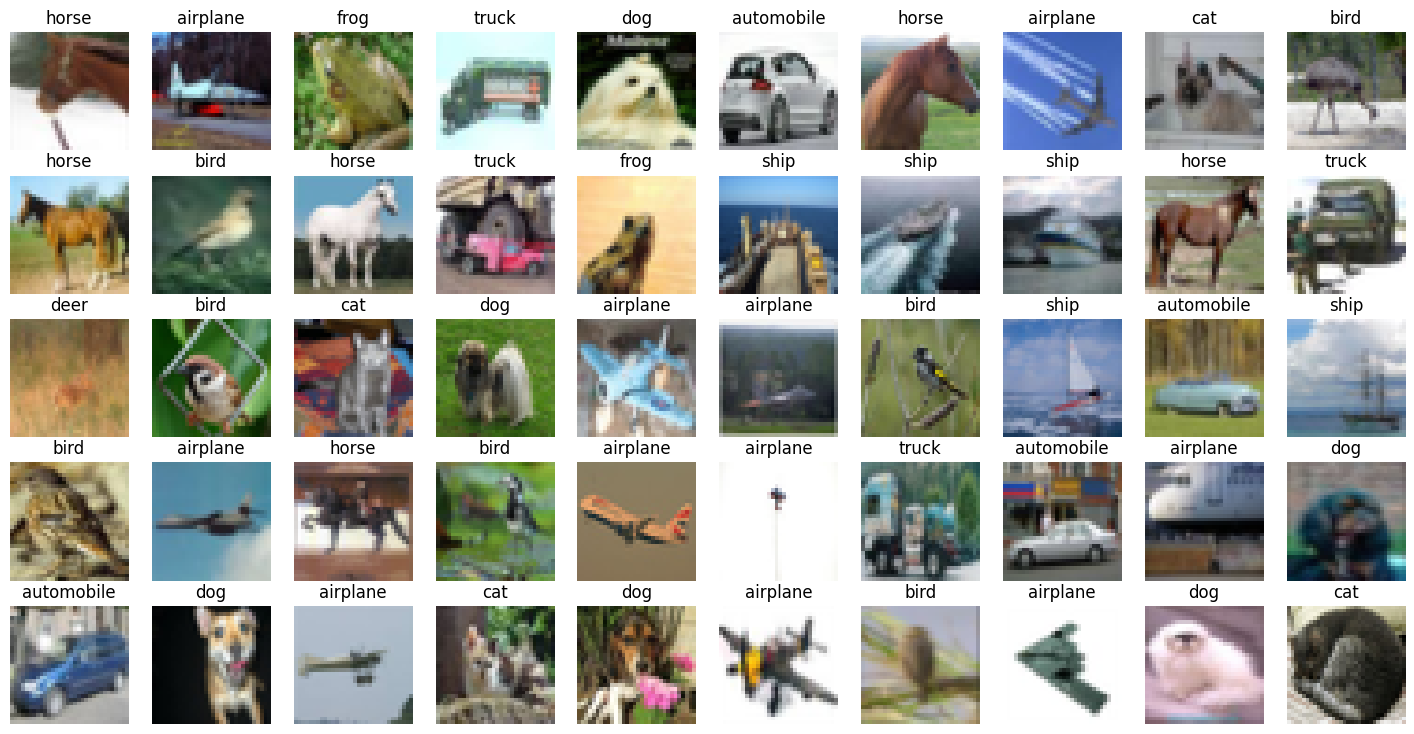

In [ ]:
plot_cifar10(images=x_test, labels=y_test, figure_array=[5, 10], figsize=(18, 9))

In [189]:
x_train = x_train.numpy().astype("float32")/255.0
x_test = x_test.numpy().astype("float32")/255.0
print(x_train.shape, np.max(x_train), np.min(x_train))
print(x_test.shape, np.max(x_test), np.min(x_test))
print(type(y_train))

(50000, 32, 32, 3) 1.0 0.0
(10000, 32, 32, 3) 1.0 0.0
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [400]:
# data augmentation
def data_augmentation(inputs, random_seed=0):
    # gray_scale_switch = ["on", "off"]
    # if random.choice(gray_scale_switch) == "on":
    #     x = keras_cv.layers.Grayscale()(inputs)
    #     print("on")
    # else:
    #     x = inputs
    #     print("off")
    x = layers.RandomRotation(factor=(0.1))(inputs)
    x = layers.RandomFlip(mode="horizontal", seed=random_seed)(x)
    return x

In [190]:
random.seed(0)
gray_scale_switch = ["on", "off"]
random.choice(gray_scale_switch)

Object `keras_cv` not found.


on


off


on


off


on


off


on


on


on


off


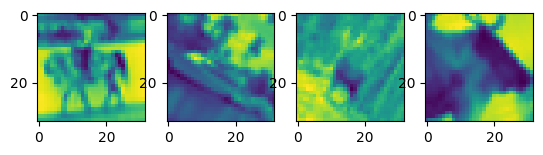

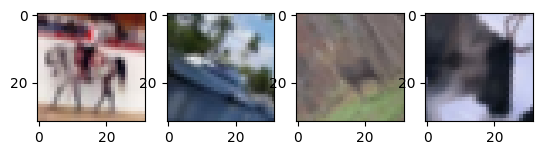

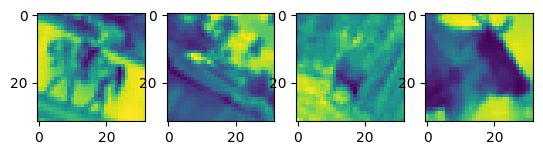

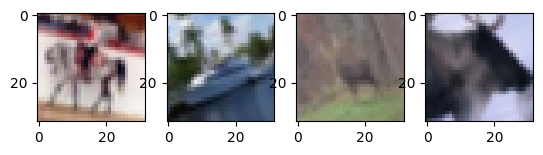

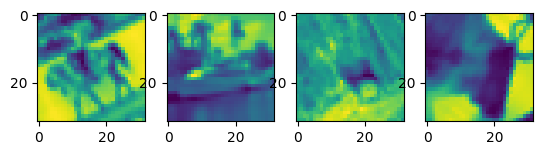

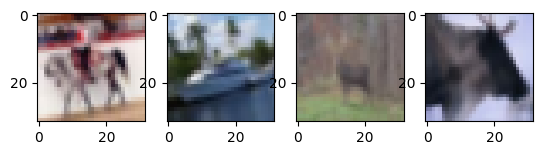

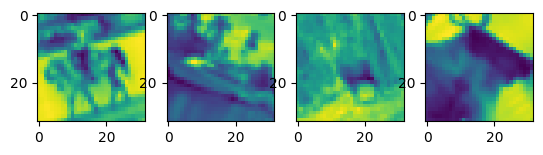

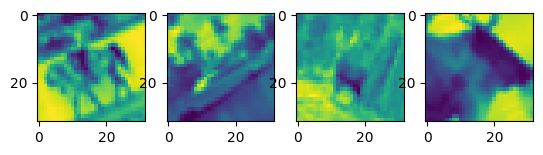

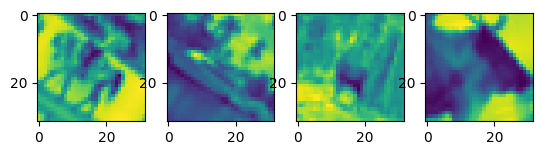

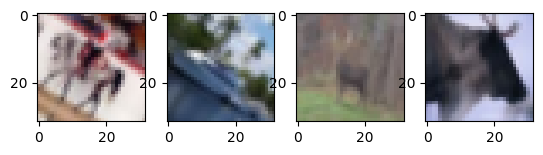

In [392]:
# inputs = keras.Input(shape=(32, 32, 3))
# x = data_augmentation(inputs)
# random_seed = 0
# x = layers.RandomFlip(mode="horizontal", seed=random_seed)(inputs)
# x = layers.RandomRotation(factor=(-0.2, 0.2), seed=random_seed)(x)
# model = keras.Model(inputs=inputs, outputs=x)
# model.summary()
for _ in range(10):
    x = data_augmentation(x_train[0:4])
    fig = plt.figure()
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    ax1.imshow(x[0])
    ax2.imshow(x[1])
    ax3.imshow(x[2])
    ax4.imshow(x[3])

In [424]:
num_classes = len(set(y_train.numpy()))
random_seed = 0
# random.seed(random_seed)
inputs = keras.Input(shape=(32, 32, 3))
# x = data_augmentation(inputs, random_seed=random_seed)
x = layers.Rescaling(scale=1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3)(x)
x = layers.BatchNormalization(momentum=0.0)(x)
x = layers.ReLU()(x)
# x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3)(x)
x = layers.BatchNormalization(momentum=0.0)(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization(momentum=0.0)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization(momentum=0.0)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization(momentum=0.0)(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.Conv2D(filters=32, kernel_size=3)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=num_classes, kernel_initializer="glorot_normal")(x)
# x = layers.Dropout(rate=0.3)(x)
outputs = layers.Softmax()(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="cnn")
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                               

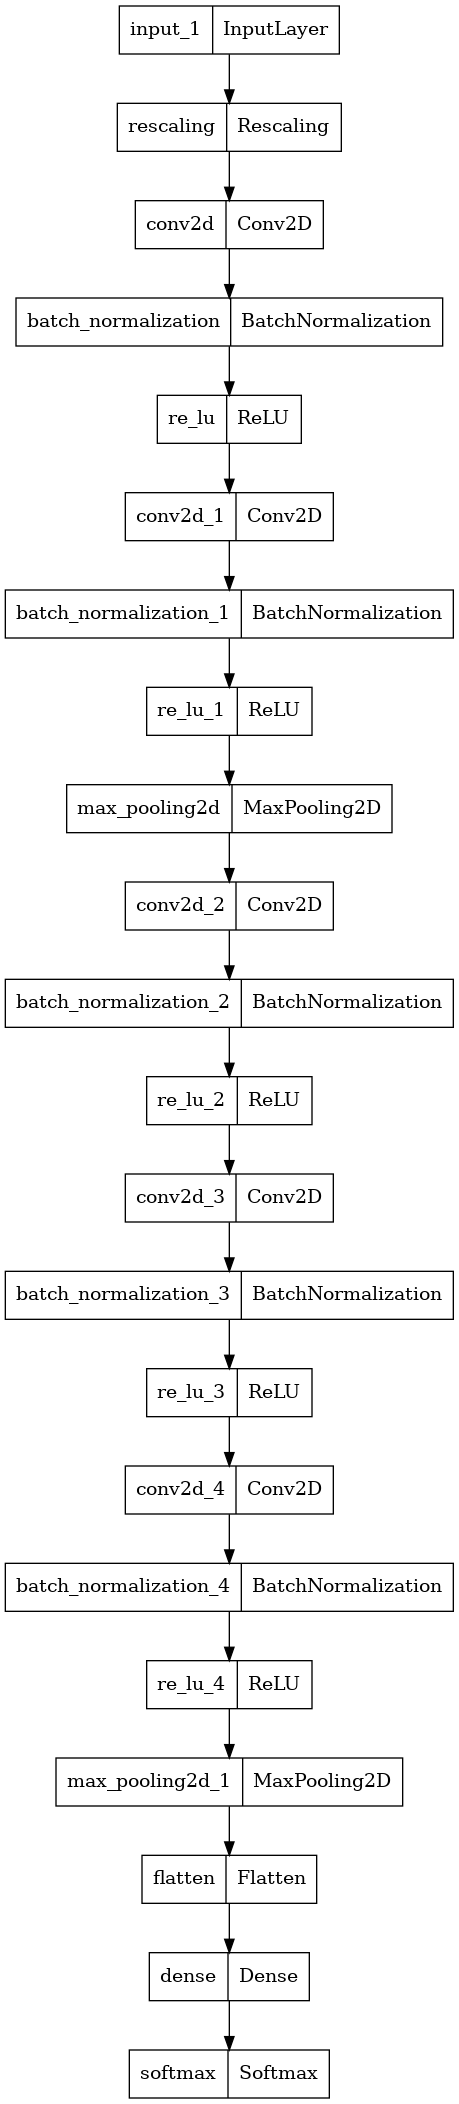

In [425]:
keras.utils.plot_model(model)

In [426]:
clear_session()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)
keras_model_path = "./keras_model/simple_cnn.keras"
tb_log_path = "./tensorboard_log/"
callbacks = [EarlyStopping(monitor="val_loss", patience=30, verbose=2, restore_best_weights=True), 
             ModelCheckpoint(filepath=keras_model_path, save_best_only=True, monitor="val_loss"),
             TensorBoard(log_dir=tb_log_path, histogram_freq=1)]
history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=128, 
                    epochs=300, verbose=2, callbacks=callbacks)

Epoch 1/300
391/391 - 7s - loss: 1.3844 - sparse_categorical_accuracy: 0.5038 - val_loss: 1.7909 - val_sparse_categorical_accuracy: 0.4323 - 7s/epoch - 18ms/step
Epoch 2/300
391/391 - 4s - loss: 0.9272 - sparse_categorical_accuracy: 0.6733 - val_loss: 1.7251 - val_sparse_categorical_accuracy: 0.4448 - 4s/epoch - 11ms/step
Epoch 3/300
391/391 - 4s - loss: 0.7673 - sparse_categorical_accuracy: 0.7317 - val_loss: 1.3308 - val_sparse_categorical_accuracy: 0.5730 - 4s/epoch - 11ms/step
Epoch 4/300
391/391 - 4s - loss: 0.6714 - sparse_categorical_accuracy: 0.7651 - val_loss: 1.5161 - val_sparse_categorical_accuracy: 0.5070 - 4s/epoch - 11ms/step
Epoch 5/300
391/391 - 4s - loss: 0.5979 - sparse_categorical_accuracy: 0.7907 - val_loss: 1.8360 - val_sparse_categorical_accuracy: 0.4506 - 4s/epoch - 11ms/step
Epoch 6/300
391/391 - 4s - loss: 0.5416 - sparse_categorical_accuracy: 0.8114 - val_loss: 0.9094 - val_sparse_categorical_accuracy: 0.6943 - 4s/epoch - 11ms/step
Epoch 7/300
391/391 - 4s - l

In [ ]:
#TensorBoardの起動
%tensorboard --logdir "./tensorboard_log"

In [ ]:
predicted_labels = model.predict(x_test).argmax(axis=1)

313/313 [==============================] - 1s 3ms/step


In [408]:
df_hist = pd.DataFrame(history.history)
df_hist["epoch"] = history.epoch
df_hist

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,epoch
0,1.808404,0.35888,1.440812,0.4885,0
1,1.530405,0.45472,1.384918,0.5183,1
2,1.415028,0.49046,1.438051,0.5095,2
3,1.332538,0.51832,1.295861,0.5455,3
4,1.273878,0.53630,1.196159,0.5901,4
...,...,...,...,...,...
98,0.738517,0.69858,0.833641,0.7397,98
99,0.734119,0.70090,1.921988,0.5410,99
100,0.729899,0.70166,1.247938,0.6519,100
101,0.736985,0.69882,1.360714,0.6304,101


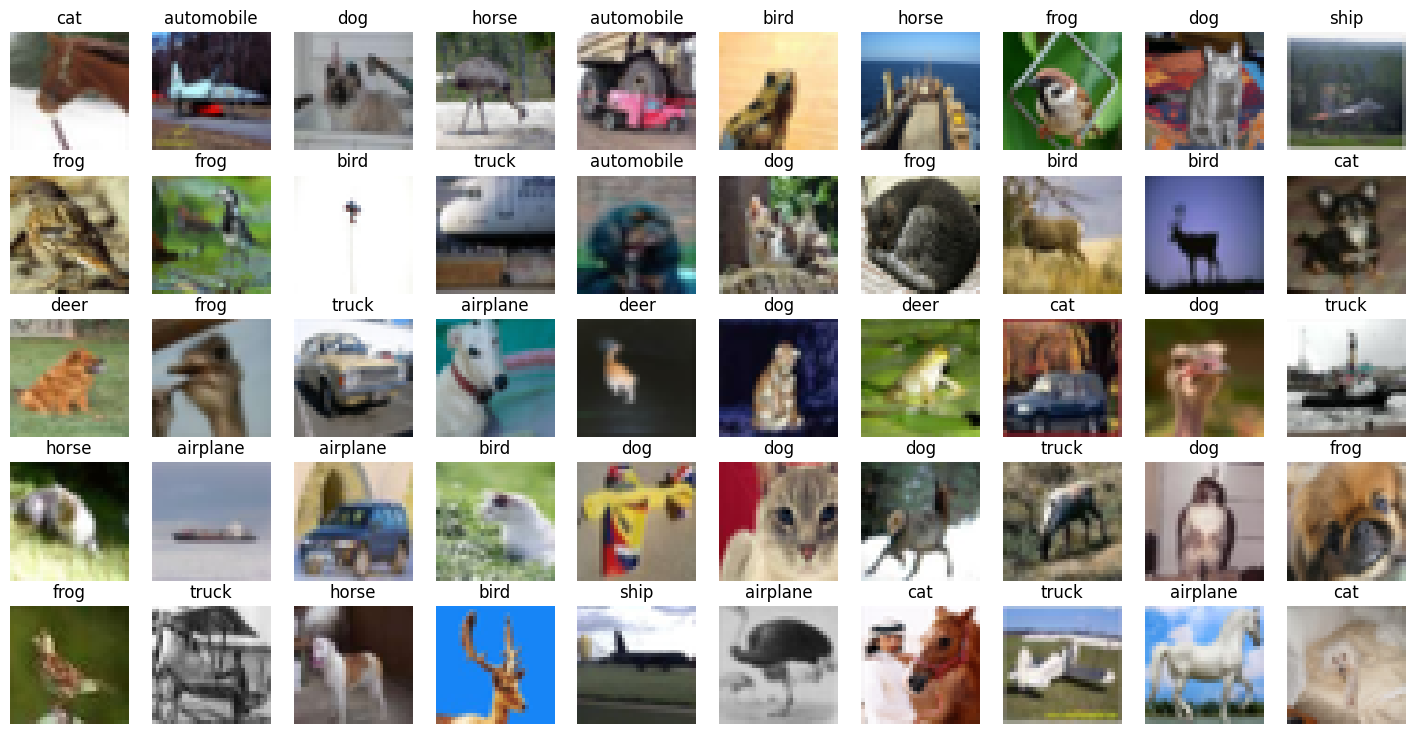

In [409]:
plot_cifar10_miss(images=x_test, real_labels=y_test, predicted_labels=predicted_labels, figure_array=[5, 10], figsize=(18,9))

In [410]:
model = keras.models.load_model(
    "./keras_model/simple_cnn.keras"
)
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 32, 32, 3)        0         
 tation)                                                         
                                                                 
 random_flip_2 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                               

In [411]:
layer_output = {}

for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_output[f"{layer.name}"] = layer.output

get_hidden_layer = keras.Model(inputs=model.input, outputs=layer_output)

In [412]:
hidden_layer_output = get_hidden_layer.predict(x_test)

313/313 [==============================] - 1s 4ms/step


In [416]:
print(hidden_layer_output.keys())
print(hidden_layer_output["conv2d_12"].shape)
print(hidden_layer_output["conv2d_12"].reshape(10000, -1).shape)

dict_keys(['conv2d_8', 'conv2d_9', 'max_pooling2d_3', 'conv2d_10', 'conv2d_11', 'conv2d_12', 'max_pooling2d_4'])
(10000, 8, 8, 64)
(10000, 4096)


In [418]:
pca = PCA(n_components=2)
dim_reduced_by_pca = pca.fit_transform(hidden_layer_output["conv2d_12"].reshape(10000, -1))
tsne = TSNE(n_components=2)
dim_reduced_by_tsne = tsne.fit_transform(hidden_layer_output["conv2d_12"].reshape(10000, -1))


In [419]:
def plot_features(features, real_labels):
    cifar10_labels = np.array([
        "airplane", 
        "automobile", 
        "bird", 
        "cat", 
        "deer", 
        "dog", 
        "frog", 
        "horse", 
        "ship", 
        "truck"
    ])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    for i in set(real_labels.numpy()):
        ax.scatter(features[real_labels==i, 0], 
                   features[real_labels==i, 1], 
                   s=40, 
                   color=matplotlib.cm.tab10(i), 
                   edgecolors="black", 
                   alpha=0.4,
                   label=cifar10_labels[i])
        ax.legend()

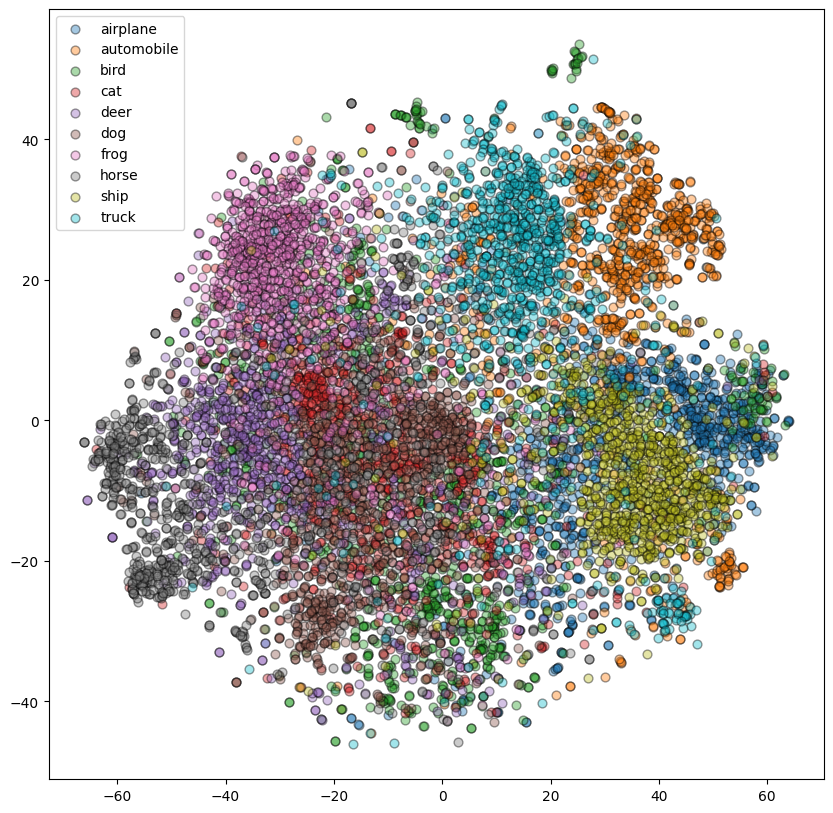

In [420]:
# plot_features(dim_reduced_by_pca, real_labels=y_test)
plot_features(dim_reduced_by_tsne, real_labels=y_test)

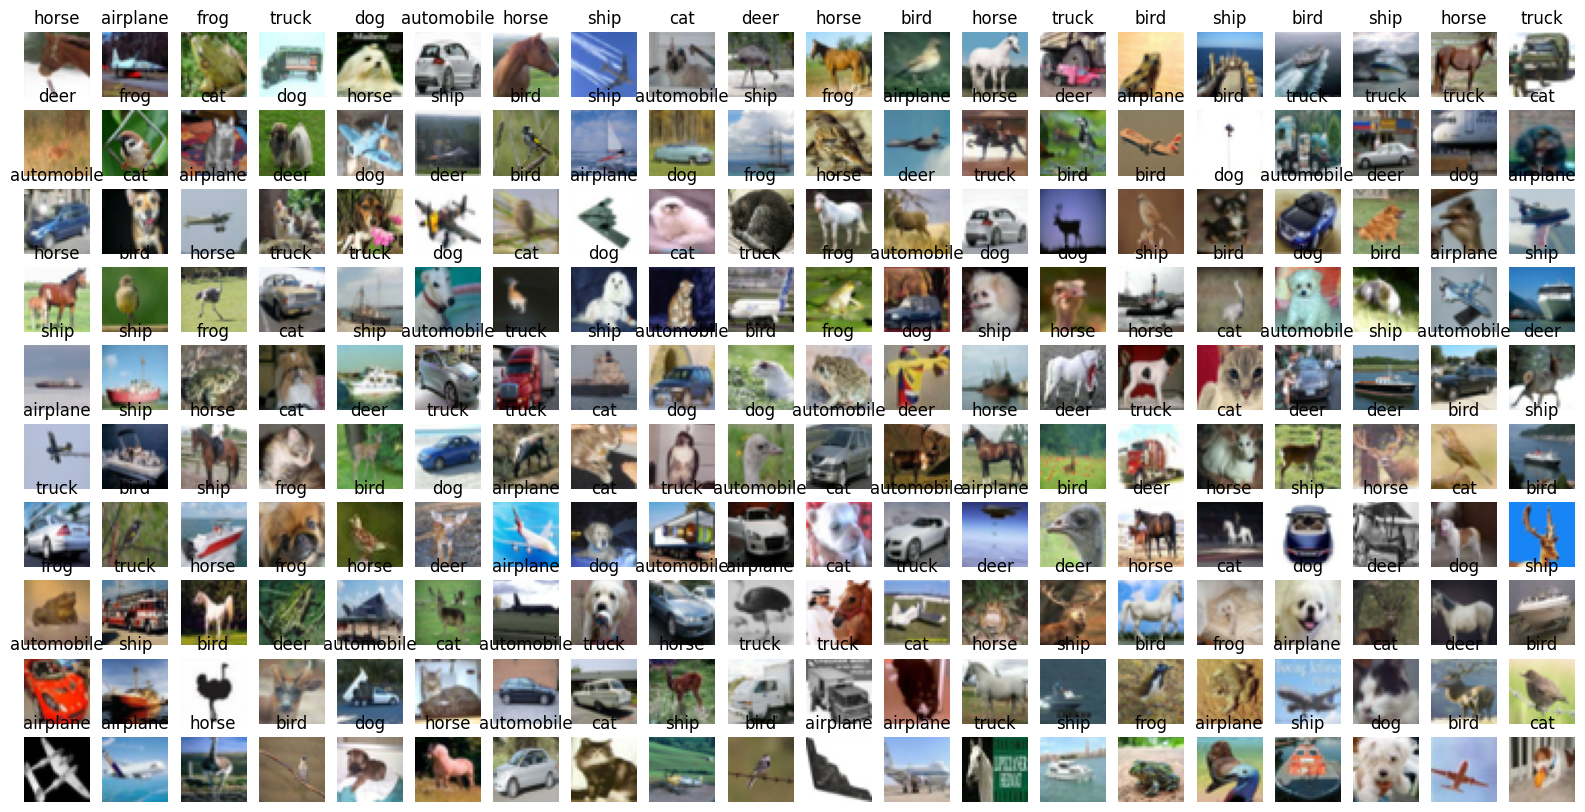

In [ ]:
plot_cifar10(images=x_test, labels=predicted_labels, figure_array=[10, 20], figsize=(20,10))